In [2]:
# Data handling
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Machine learning: preprocessing and feature engineering
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.feature_selection import VarianceThreshold, RFECV

# Machine learning: models
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

# Machine learning: model selection and evaluation
from sklearn.model_selection import StratifiedKFold, cross_validate, GridSearchCV, train_test_split
from sklearn.metrics import (
    accuracy_score, auc, classification_report, confusion_matrix, 
    precision_recall_curve, roc_curve, RocCurveDisplay, average_precision_score,
    make_scorer
)

# Imbalanced data handling
from imblearn.over_sampling import BorderlineSMOTE, SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

### Preprocessing 

In [3]:
# Load dataset
df = pd.read_csv("NHANES_data_stroke_train.csv")

# Perform imputation for missing values (example with mean imputation for simplicity)
imputer = SimpleImputer(strategy='mean')
df_imputed = pd.DataFrame(imputer.fit_transform(df), columns=df.columns)

# Convert 'NA' strings to actual NA values and map {2, 1} to {0, 1} for binary features
# df_imputed = df_imputed.replace({'NA': pd.NA, '2': 0, '1': 1})

# Ensure all categorical features are of type 'category' (important for OneHotEncoder in preprocessor)
categorical_features = ['Sex', 'Race', 'CurrentSmoker', 'isActive', 'isInsured', 'Diabetes']
df_imputed[categorical_features] = df_imputed[categorical_features].astype('category')

# Split dataset
X = df_imputed.drop('stroke', axis=1)
y = df_imputed['stroke']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Make a copy for later use
SEQN_train = X_train['SEQN'].copy()
SEQN_test = X_test['SEQN'].copy()

# Drop 'SEQN' column if it exists
X_train = X_train.drop(columns=['SEQN'], errors='ignore')
X_test = X_test.drop(columns=['SEQN'], errors='ignore')

# Initialize the classifier
classifier = RandomForestClassifier(random_state=42)

# Feature selector with cross-validation
selector = RFECV(estimator=classifier, step=3, cv=StratifiedKFold(3),
                 scoring=make_scorer(accuracy_score))

# Fit RFECV
selector = selector.fit(X_train, y_train)

# Report the optimal number of features and which are selected
print(f"Optimal number of features: {selector.n_features_}")
print(f"Best features: {X_train.columns[selector.support_]}")

# Select the features that were determined to be most important
selected_features = X_train.columns[selector.support_]

# Initialize the scaler
scaler = MinMaxScaler()

# Scale the selected features of the training and testing set
X_train_scaled = scaler.fit_transform(X_train[selected_features])
X_test_scaled = scaler.transform(X_test[selected_features])

# Update the datasets
X_train = pd.DataFrame(X_train_scaled, columns=selected_features, index=X_train.index)
X_test = pd.DataFrame(X_test_scaled, columns=selected_features, index=X_test.index)

# Apply SMOTE to address class imbalance
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Update the classifier to use the data balanced by SMOTE
selector = selector.fit(X_train_smote, y_train_smote)


Optimal number of features: 15
Best features: Index(['Income', 'Age', 'Race', 'Edu', 'Diastolic', 'Systolic', 'Pulse', 'BMI',
       'HDL', 'Trig', 'LDL', 'TCHOL', 'kidneys_eGFR', 'Diabetes',
       'CurrentSmoker'],
      dtype='object')


### Decision Tree

In [4]:
dt_classifier = DecisionTreeClassifier(max_depth=30, min_samples_leaf=2, min_samples_split=2, random_state=42)

# Train the Decision Tree Classifier with the best hyperparameters using already processed data
dt_classifier.fit(X_train_smote, y_train_smote)

# Predict with the trained Decision Tree
y_pred_dt = dt_classifier.predict(X_test)

# Evaluation
print("Accuracy:", accuracy_score(y_test, y_pred_dt))
print(classification_report(y_test, y_pred_dt))

Accuracy: 0.8571428571428571
              precision    recall  f1-score   support

         1.0       0.10      0.28      0.15        36
         2.0       0.96      0.88      0.92       783

    accuracy                           0.86       819
   macro avg       0.53      0.58      0.53       819
weighted avg       0.93      0.86      0.89       819



### SVM

In [5]:
svm_classifier = SVC(C=1.0, kernel='rbf', gamma='scale', random_state=42, probability=True)

# Train the SVM Classifier with the best hyperparameters using already processed data
svm_classifier.fit(X_train_smote, y_train_smote)

# Predict with the trained SVM
y_pred_svm = svm_classifier.predict(X_test)

# Evaluation
print("Accuracy:", accuracy_score(y_test, y_pred_svm))
print(classification_report(y_test, y_pred_svm))

Accuracy: 0.8144078144078144
              precision    recall  f1-score   support

         1.0       0.10      0.42      0.16        36
         2.0       0.97      0.83      0.90       783

    accuracy                           0.81       819
   macro avg       0.54      0.62      0.53       819
weighted avg       0.93      0.81      0.86       819



### Random Forest

In [6]:
rf_classifier = RandomForestClassifier(n_estimators=200, min_samples_split=2, min_samples_leaf=1, random_state=42)

# Train the RandomForest Classifier
rf_classifier.fit(X_train_smote, y_train_smote)

# Predict with the trained RandomForest
y_pred_rf = rf_classifier.predict(X_test)

# Evaluation
print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))

Classification Report for RandomForest:
Accuracy: 0.938949938949939
              precision    recall  f1-score   support

         1.0       0.25      0.19      0.22        36
         2.0       0.96      0.97      0.97       783

    accuracy                           0.94       819
   macro avg       0.61      0.58      0.59       819
weighted avg       0.93      0.94      0.94       819



### Gradient Boosting

In [7]:
gb_classifier = GradientBoostingClassifier(
    n_estimators=200, min_samples_split=2, min_samples_leaf=1, random_state=42
)

# Train the Gradient Boosting Classifier with the best hyperparameters using already processed data
gb_classifier.fit(X_train_smote, y_train_smote)

# Predict with the trained Gradient Boosting
y_pred_gb = gb_classifier.predict(X_test)

# Evaluation
print("Accuracy:", accuracy_score(y_test, y_pred_gb))
print(classification_report(y_test, y_pred_gb))


Classification Report for Gradient Boosting:
Accuracy: 0.905982905982906
              precision    recall  f1-score   support

         1.0       0.16      0.28      0.21        36
         2.0       0.97      0.93      0.95       783

    accuracy                           0.91       819
   macro avg       0.56      0.61      0.58       819
weighted avg       0.93      0.91      0.92       819



## Testing models with test Data

In [8]:
test_data_path = 'NHANES_data_stroke_test4Students.csv'

# Read the CSV file into a pandas DataFrame
test_df = pd.read_csv(test_data_path)

test_df = test_df.rename(columns={'ParticipantID': 'SEQN'})

# Impute missing values
test_df_imputed = pd.DataFrame(imputer.transform(test_df), columns=test_df.columns)

# Convert categorical features
test_df_imputed[categorical_features] = test_df_imputed[categorical_features].astype('category')

# Extract SEQN for identification
SEQN_test = test_df_imputed['SEQN'].copy()

# Drop 'SEQN' and any other columns not among the 15 best features
test_X_prepared = test_df_imputed.drop(columns=['SEQN'] + [col for col in test_df_imputed.columns if col not in selected_features])

test_X_scaled = scaler.transform(test_X_prepared)

test_X_final = pd.DataFrame(test_X_scaled, columns=selected_features, index=SEQN_test.index)

print("Test data loaded successfully.")

def predict_stroke_probabilities(model, model_name, X_test, SEQN_test, save_to_csv=False):
    """
    Predicts stroke probabilities for a given model and test data.

    Parameters:
    - model: The trained machine learning model.
    - model_name: A string, the name of the model for labeling purposes.
    - X_test: Test features without the stroke column.
    - SEQN_test: Series or array containing SEQN IDs corresponding to X_test.
    - save_to_csv: Boolean, whether to save the predictions to a CSV file.
    """
    
    # Check if the model can predict probabilities
    if hasattr(model, "predict_proba"):
        # Assuming the positive class (stroke) is the second column
        predictions = model.predict_proba(X_test)[:, 1]
    else:
        # For models that do not support predict_proba, use predict
        predictions = model.predict(X_test)
    
    # Creating a DataFrame to hold SEQN and the predicted probabilities or classes
    results_df = pd.DataFrame({
        'SEQN': SEQN_test,
        'Stroke_Probability': predictions
    })
    
    # Display the first few predictions
    print(f"First few stroke predictions by {model_name}:")
    print(results_df.head())
    
    # Optionally save to a CSV file
    if save_to_csv:
        csv_path = f"{model_name}_pred.csv"
        results_df.to_csv(csv_path, index=False)
        print(f"Predictions saved to {csv_path}")

# Example usage:
# Assuming `new_X_test` is your test features DataFrame and `new_SEQN_test` contains corresponding SEQN IDs
# predict_stroke_probabilities(your_model, "Your Model Name", new_X_test, new_SEQN_test, save_to_csv=True)

predict_stroke_probabilities(dt_classifier, "Decision_Tree", test_X_final, SEQN_test, save_to_csv=True)
predict_stroke_probabilities(svm_classifier, "SVM", test_X_final, SEQN_test, save_to_csv=True)
predict_stroke_probabilities(rf_classifier, "Random_Forest", test_X_final, SEQN_test, save_to_csv=True)
predict_stroke_probabilities(gb_classifier, "Gradient_Boosting", test_X_final, SEQN_test, save_to_csv=True)




Test data loaded successfully.
First few stroke predictions by Decision_Tree:
     SEQN  Stroke_Probability
0  1001.0                 1.0
1  1002.0                 1.0
2  1003.0                 1.0
3  1004.0                 1.0
4  1005.0                 1.0
First few stroke predictions by SVM:
     SEQN  Stroke_Probability
0  1001.0            0.977867
1  1002.0            0.914805
2  1003.0            0.964870
3  1004.0            0.933369
4  1005.0            0.701218
First few stroke predictions by Random_Forest:
     SEQN  Stroke_Probability
0  1001.0               0.980
1  1002.0               0.830
2  1003.0               0.860
3  1004.0               0.945
4  1005.0               0.735
First few stroke predictions by Gradient_Boosting:
     SEQN  Stroke_Probability
0  1001.0            0.977279
1  1002.0            0.855039
2  1003.0            0.957647
3  1004.0            0.989401
4  1005.0            0.648398


## Model Evaluation

Decision Tree Performance:
Accuracy: 0.8571
Classification Report:
              precision    recall  f1-score   support

         1.0       0.10      0.28      0.15        36
         2.0       0.96      0.88      0.92       783

    accuracy                           0.86       819
   macro avg       0.53      0.58      0.53       819
weighted avg       0.93      0.86      0.89       819




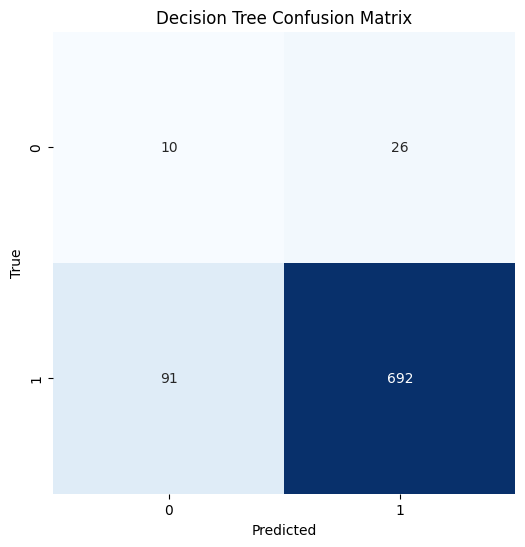

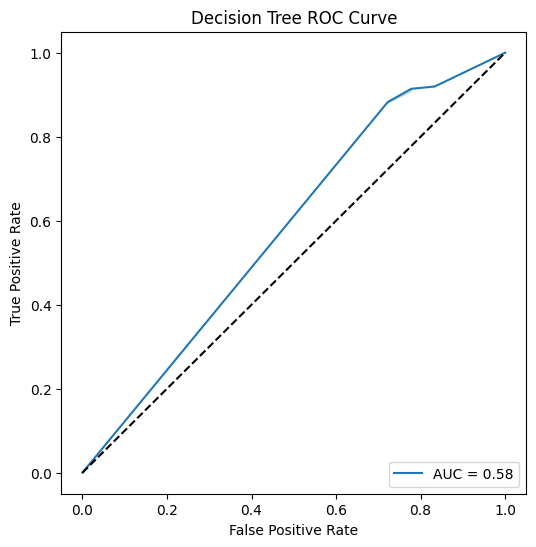

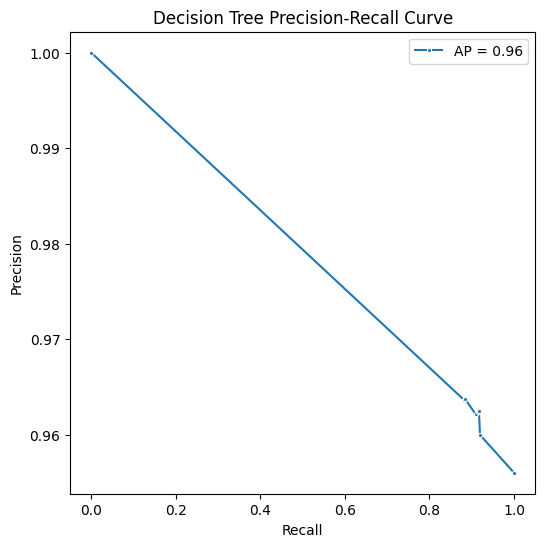

/tmp/ipykernel_6461/1189785774.py:52: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=np.array(feature_names)[indices], y=importances[indices], palette='Blues_d')


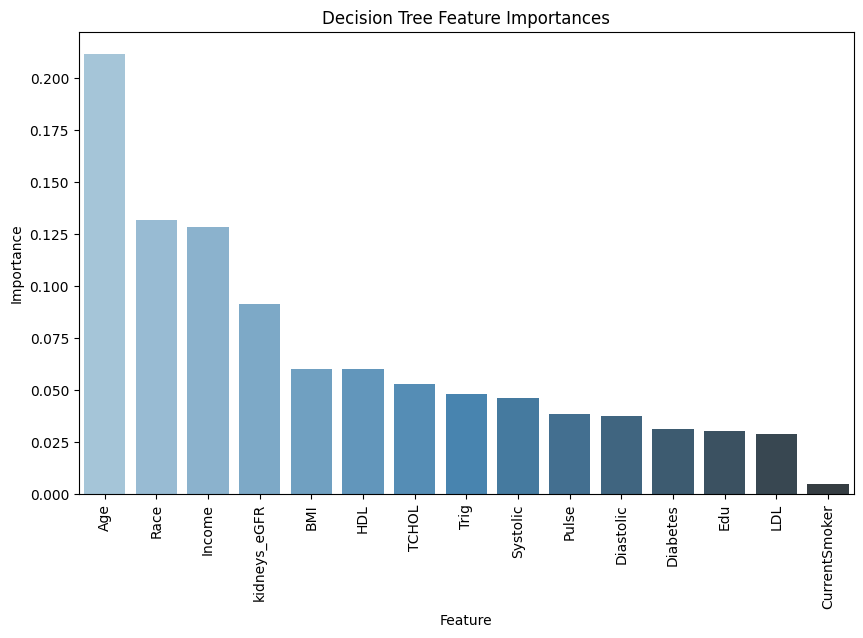

SVM Performance:
Accuracy: 0.8144
Classification Report:
              precision    recall  f1-score   support

         1.0       0.10      0.42      0.16        36
         2.0       0.97      0.83      0.90       783

    accuracy                           0.81       819
   macro avg       0.54      0.62      0.53       819
weighted avg       0.93      0.81      0.86       819




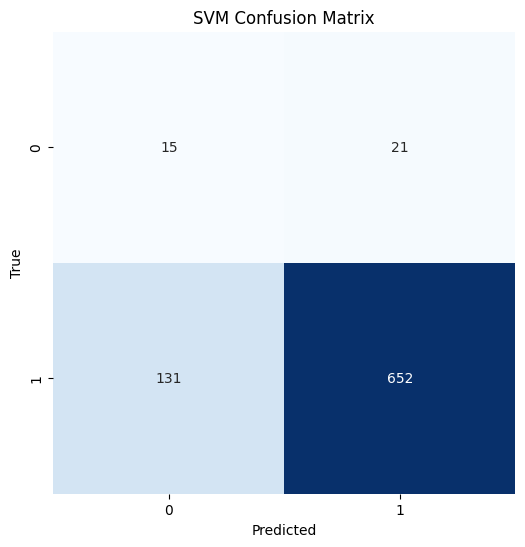

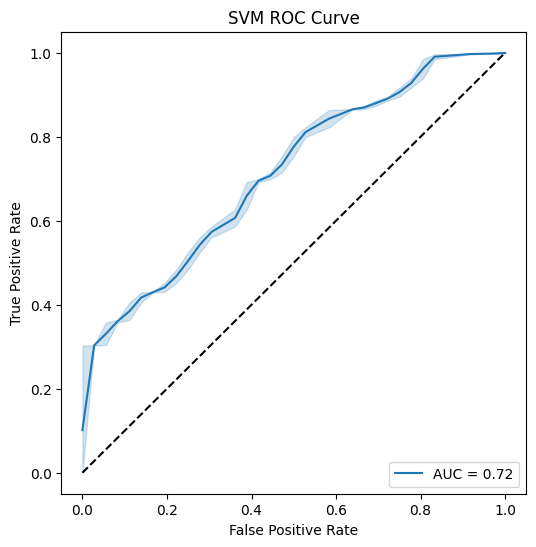

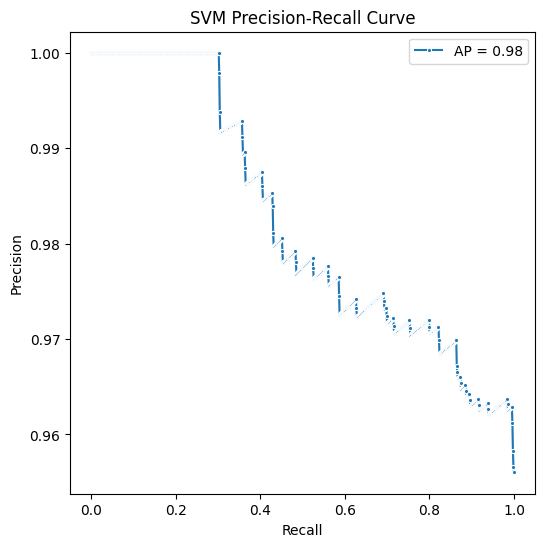

Random Forest Performance:
Accuracy: 0.9389
Classification Report:
              precision    recall  f1-score   support

         1.0       0.25      0.19      0.22        36
         2.0       0.96      0.97      0.97       783

    accuracy                           0.94       819
   macro avg       0.61      0.58      0.59       819
weighted avg       0.93      0.94      0.94       819




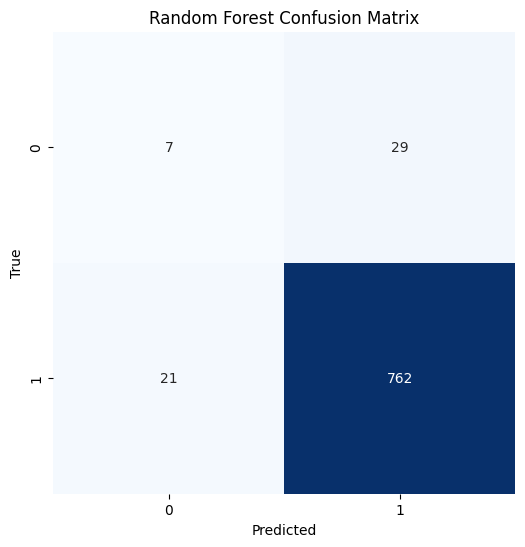

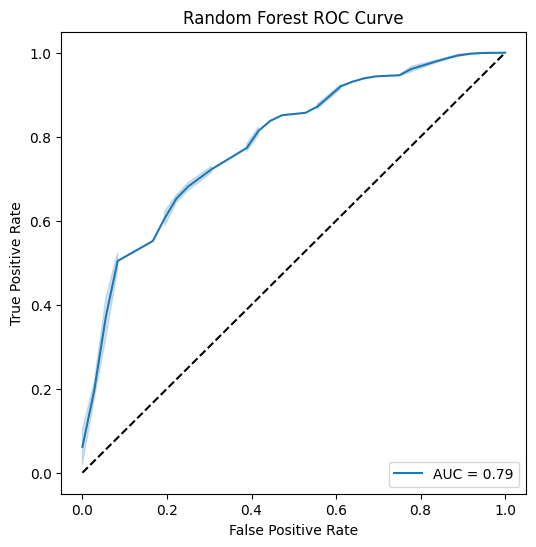

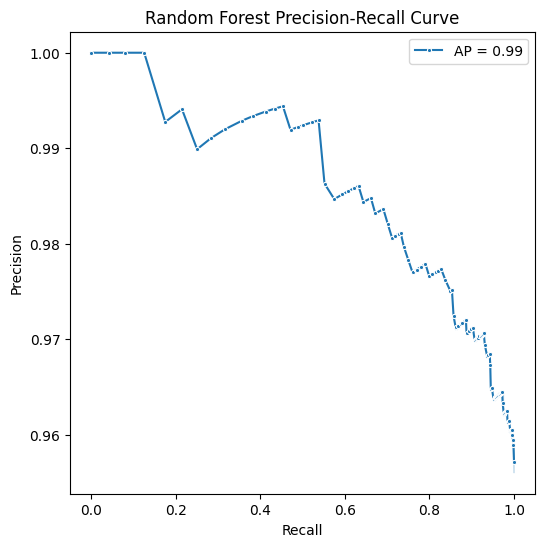

/tmp/ipykernel_6461/1189785774.py:52: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=np.array(feature_names)[indices], y=importances[indices], palette='Blues_d')


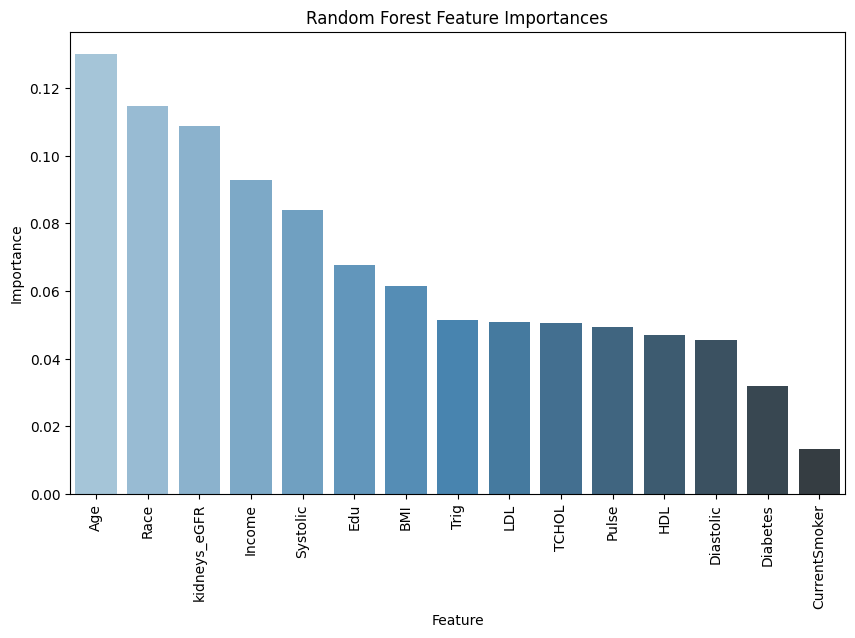

Gradient Boosting Performance:
Accuracy: 0.9060
Classification Report:
              precision    recall  f1-score   support

         1.0       0.16      0.28      0.21        36
         2.0       0.97      0.93      0.95       783

    accuracy                           0.91       819
   macro avg       0.56      0.61      0.58       819
weighted avg       0.93      0.91      0.92       819




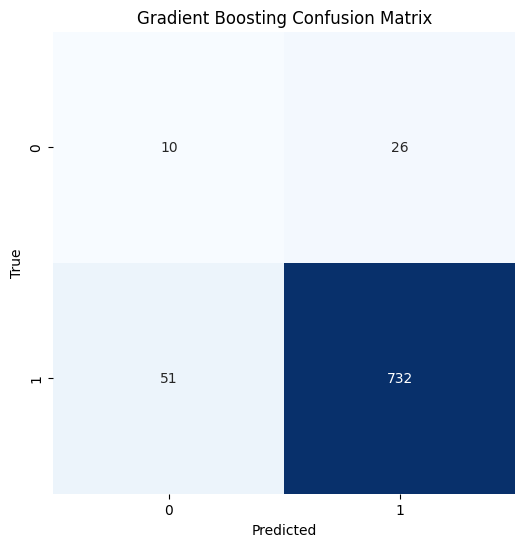

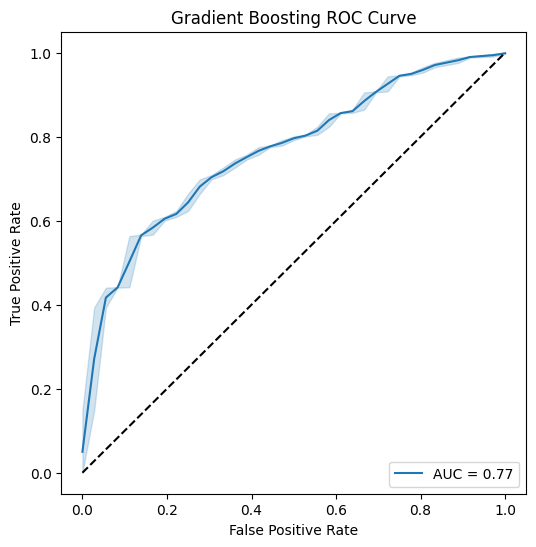

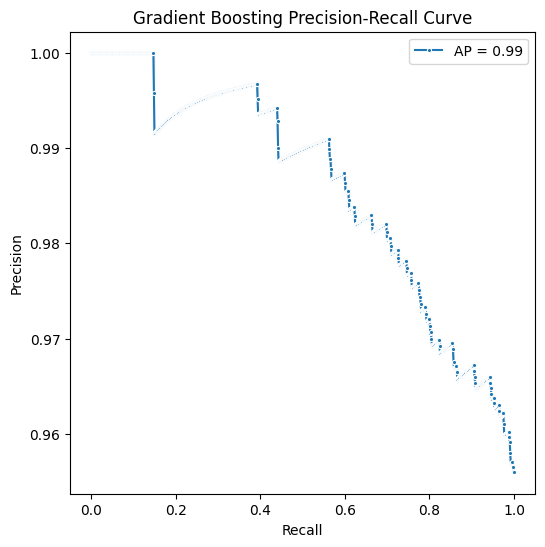

/tmp/ipykernel_6461/1189785774.py:52: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=np.array(feature_names)[indices], y=importances[indices], palette='Blues_d')


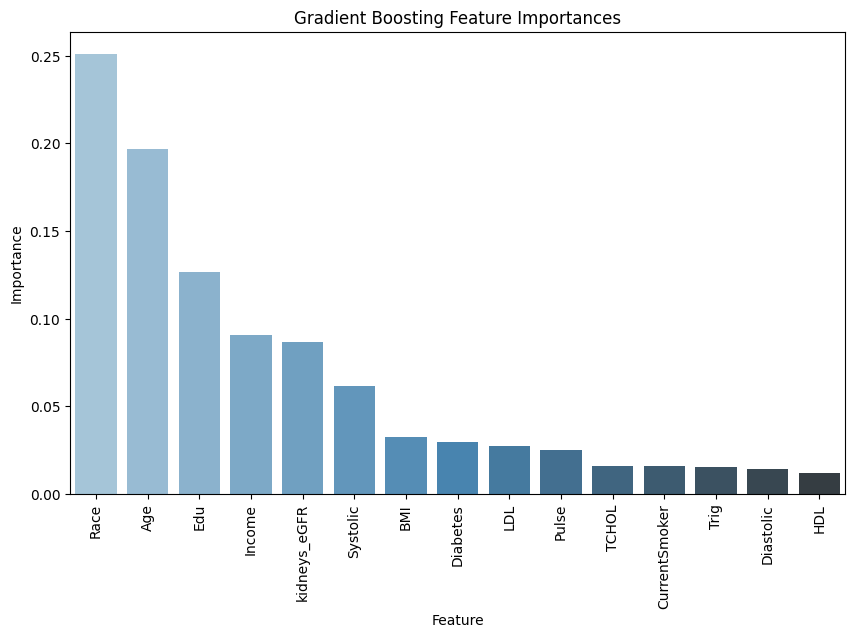

In [9]:
def evaluate_model(model, model_name, X_test, y_test, feature_names=None):
    """
    Evaluates a machine learning model's performance and displays relevant metrics and plots.
    """
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    
    # Basic Evaluation Metrics
    print(f"{model_name} Performance:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Classification Report:\n{classification_report(y_test, y_pred, zero_division=0)}\n")
    
    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", square=True, cbar=False)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f"{model_name} Confusion Matrix")
    plt.show()
    
    # ROC Curve and AUC
    if hasattr(model, "predict_proba"):
        y_prob = model.predict_proba(X_test)[:, 1]
        fpr, tpr, _ = roc_curve(y_test, y_prob, pos_label=2.0)
        roc_auc = auc(fpr, tpr)
        plt.figure(figsize=(6, 6))
        sns.lineplot(x=fpr, y=tpr, label=f'AUC = {roc_auc:.2f}')
        plt.plot([0, 1], [0, 1], 'k--')  # Dashed diagonal
        plt.title(f'{model_name} ROC Curve')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.legend(loc='lower right')
        plt.show()
    
        # Precision-Recall Curve and Average Precision
        precision, recall, _ = precision_recall_curve(y_test, y_prob, pos_label=2.0)
        ap_score = average_precision_score(y_test, y_prob, pos_label=2.0)
        plt.figure(figsize=(6, 6))
        sns.lineplot(x=recall, y=precision, marker='.', label=f'AP = {ap_score:.2f}')
        plt.title(f'{model_name} Precision-Recall Curve')
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.legend()
        plt.show()
    
    # Feature Importances
    if hasattr(model, "feature_importances_") and feature_names is not None:
        importances = model.feature_importances_
        indices = np.argsort(importances)[::-1]
        plt.figure(figsize=(10, 6))
        sns.barplot(x=np.array(feature_names)[indices], y=importances[indices], palette='Blues_d')
        plt.xticks(rotation=90)
        plt.title(f'{model_name} Feature Importances')
        plt.ylabel('Importance')
        plt.xlabel('Feature')
        plt.show()
    elif 'classifier' in dir(model) and hasattr(model.classifier, "feature_importances_"):
        # This handles the case where the model is part of a pipeline and named 'classifier'
        importances = model.classifier.feature_importances_
        indices = np.argsort(importances)[::-1]
        plt.figure(figsize=(10, 6))
        sns.barplot(x=np.array(feature_names)[indices], y=importances[indices], palette='Blues_d')
        plt.xticks(rotation=90)
        plt.title(f'{model_name} Feature Importances')
        plt.ylabel('Importance')
        plt.xlabel('Feature')
        plt.show()
        
        
evaluate_model(dt_classifier, "Decision Tree", X_test, y_test, feature_names=X_train.columns.tolist())
evaluate_model(svm_classifier, "SVM", X_test, y_test)
evaluate_model(rf_classifier, "Random Forest", X_test, y_test, feature_names=X_train.columns.tolist())
evaluate_model(gb_classifier, "Gradient Boosting", X_test, y_test, feature_names=X_train.columns.tolist())
